## importing packages

In [1]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

import folium
import json

import pandas as pd
import numpy as np

## reading data

In [331]:
data_name = 'test02'
with open('dataset/{0}.json'.format(data_name), 'r', encoding='utf-8') as file:
    data = json.load(file)

In [332]:
print('objects:', data.keys())
print('N:', len(data['locations']))
print('K:', data['K'])

objects: dict_keys(['locations', 'matrix', 'K'])
N: 321
K: 13


In [333]:
df = pd.DataFrame(data['locations'])
df

,lat,lng
0,49.963948,82.578295
1,50.026257,82.740470
2,49.958195,82.629735
3,50.030384,82.736735
4,50.007576,82.684397
...,...,...
316,49.895094,82.706801
317,49.906258,82.676375
318,49.966112,82.591068
319,49.964843,82.584001


In [334]:
distances = np.array(data['matrix'])
distances

array([[    0. , 16143.2,  5074.6, ...,  1416.3,   932. ,  3005.7],
       [16027.2,     0. , 12831. , ..., 14572.9, 15157.5, 13838.2],
       [ 4818. , 12753.7,     0. , ...,  3913.3,  4497.9,  2277.8],
       ...,
       [ 1419.5, 15182.4,  4074.6, ...,     0. ,   685. ,  2005.7],
       [  932. , 15763.7,  4655.9, ...,   681.7,     0. ,  2587. ],
       [ 2540.2, 13547.8,  2428.3, ...,  1994.9,  2579.4,     0. ]])

In [335]:
from sklearn.metrics.pairwise import cosine_similarity

cos_dist = cosine_similarity(distances, distances)
print(cos_dist)

[[1.         0.73532515 0.92877226 ... 0.99622772 0.99843502 0.97803917]
 [0.73532515 1.         0.78551038 ... 0.71743297 0.72478218 0.74297389]
 [0.92877226 0.78551038 1.         ... 0.93675743 0.93044952 0.97663775]
 ...
 [0.99622772 0.71743297 0.93675743 ... 1.         0.99894308 0.98478014]
 [0.99843502 0.72478218 0.93044952 ... 0.99894308 1.         0.97983895]
 [0.97803917 0.74297389 0.97663775 ... 0.98478014 0.97983895 1.        ]]


In [336]:
X = cos_dist.copy()
# X = cos_dist[~np.eye(cos_dist.shape[0],dtype=bool)].reshape((cos_dist.shape[0], cos_dist.shape[1]-1))
X = np.hstack([X, df.values.copy()])
coords = df.values.copy()

print(X[:5])
print(coords[:5])

[[ 1.          0.73532515  0.92877226 ...  0.97803917 49.963948
  82.578295  ]
 [ 0.73532515  1.          0.78551038 ...  0.74297389 50.026257
  82.74047   ]
 [ 0.92877226  0.78551038  1.         ...  0.97663775 49.958195
  82.629735  ]
 [ 0.73567002  0.99998403  0.78595594 ...  0.74341927 50.030384
  82.736735  ]
 [ 0.78574912  0.98866358  0.84434823 ...  0.80410784 50.007576
  82.684397  ]]
[[49.963948 82.578295]
 [50.026257 82.74047 ]
 [49.958195 82.629735]
 [50.030384 82.736735]
 [50.007576 82.684397]]


## used to get better model and high silhouette scores, but it has some insights there

In [337]:
%%time
from sklearn.decomposition import PCA

if len(data['locations']) > 1000:
    pca = PCA(n_components=1000)
    X = pca.fit_transform(X)
print(X[:5])

[[ 1.          0.73532515  0.92877226 ...  0.97803917 49.963948
  82.578295  ]
 [ 0.73532515  1.          0.78551038 ...  0.74297389 50.026257
  82.74047   ]
 [ 0.92877226  0.78551038  1.         ...  0.97663775 49.958195
  82.629735  ]
 [ 0.73567002  0.99998403  0.78595594 ...  0.74341927 50.030384
  82.736735  ]
 [ 0.78574912  0.98866358  0.84434823 ...  0.80410784 50.007576
  82.684397  ]]
Wall time: 962 µs


## testing some models for its analysis

For n_clusters = 2 The average silhouette_score is : 0.4909623209954988
For n_clusters = 3 The average silhouette_score is : 0.5665021002054689
For n_clusters = 4 The average silhouette_score is : 0.5974034085310633
For n_clusters = 5 The average silhouette_score is : 0.5356728638734058
For n_clusters = 6 The average silhouette_score is : 0.5611603244789203
For n_clusters = 7 The average silhouette_score is : 0.5493602533665274
For n_clusters = 8 The average silhouette_score is : 0.562902985046274
For n_clusters = 9 The average silhouette_score is : 0.5845092567301159
For n_clusters = 10 The average silhouette_score is : 0.5824349094724597
For n_clusters = 11 The average silhouette_score is : 0.591651684971282
For n_clusters = 12 The average silhouette_score is : 0.5816320067575701
For n_clusters = 13 The average silhouette_score is : 0.5744487670079184


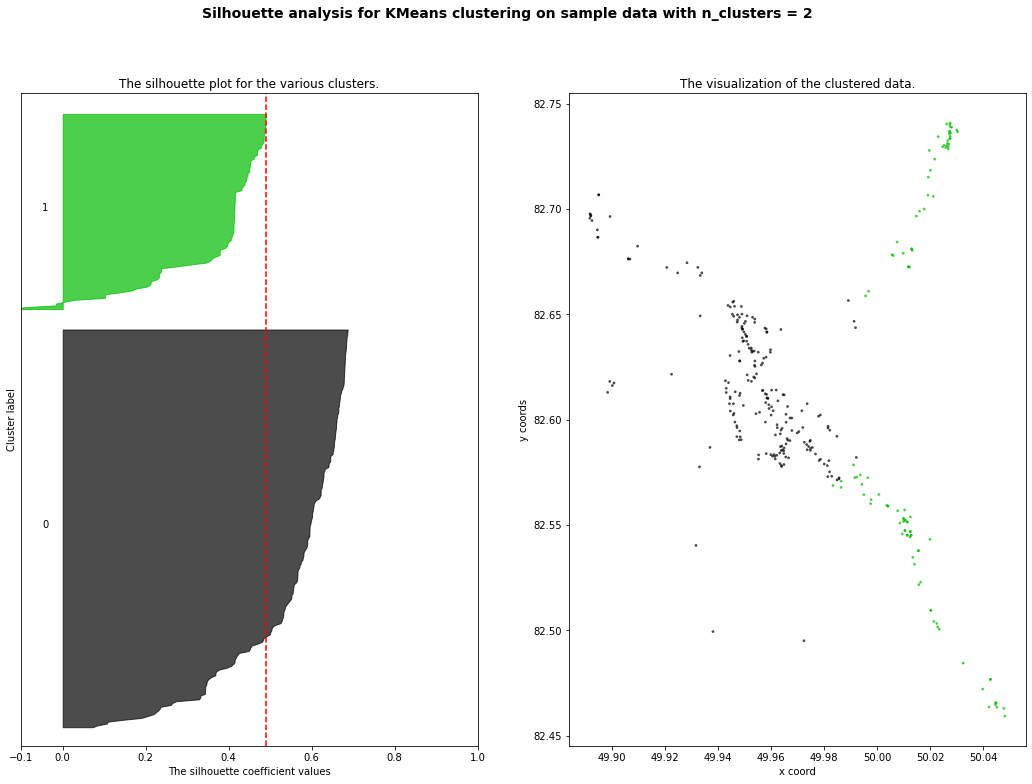

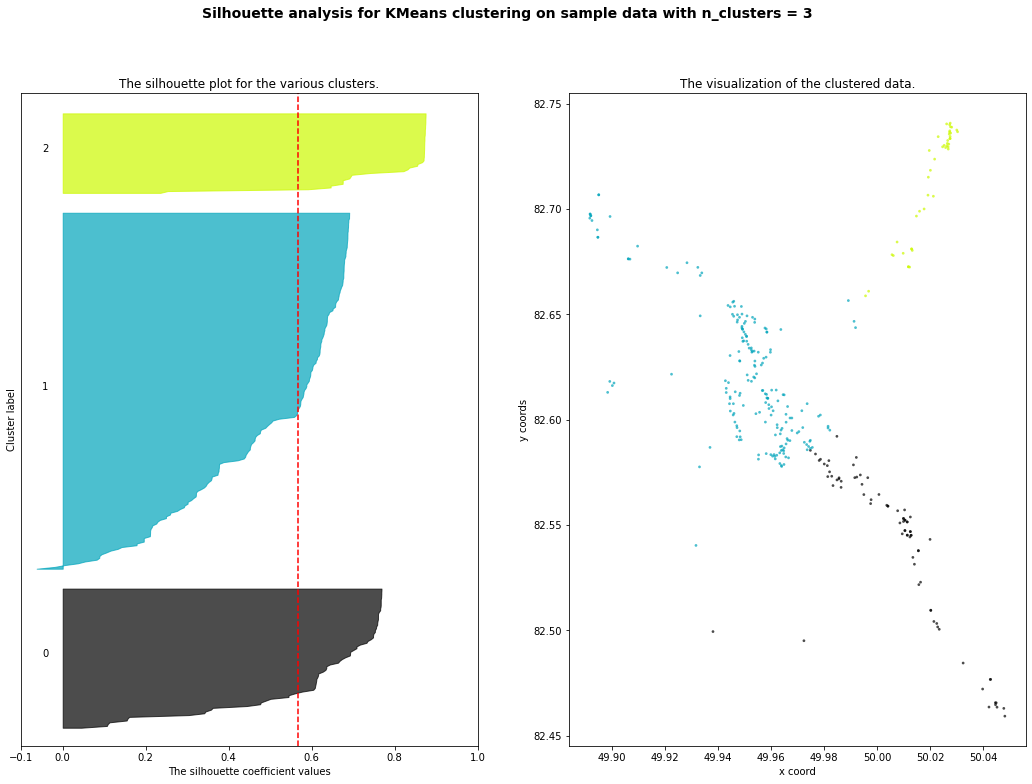

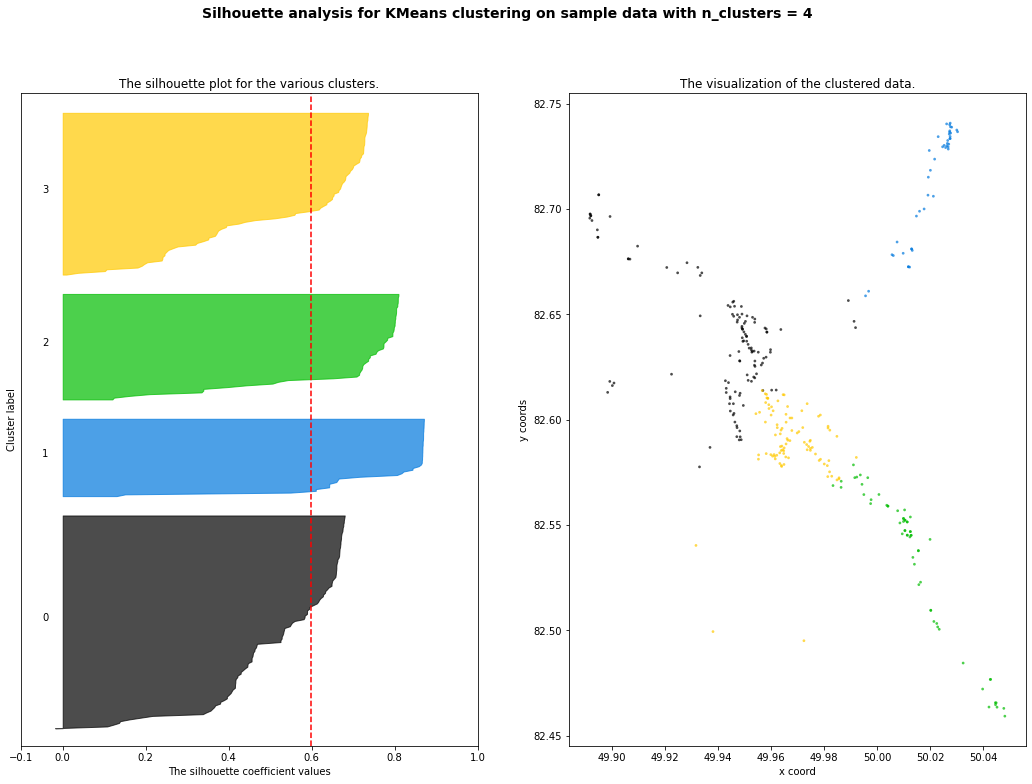

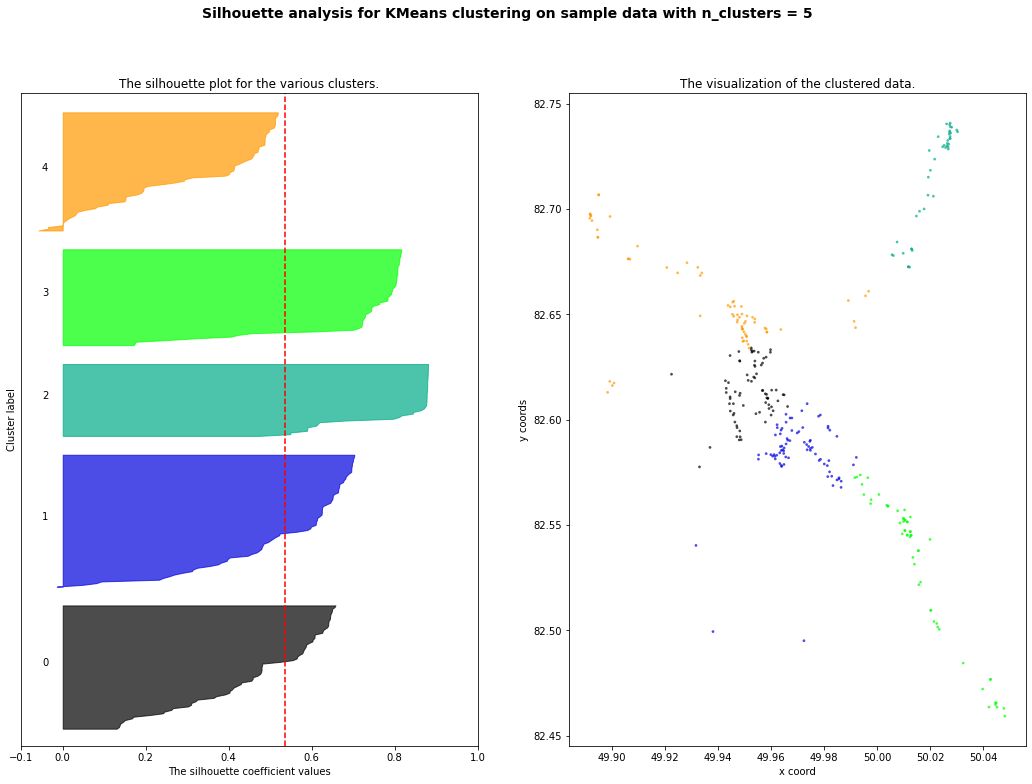

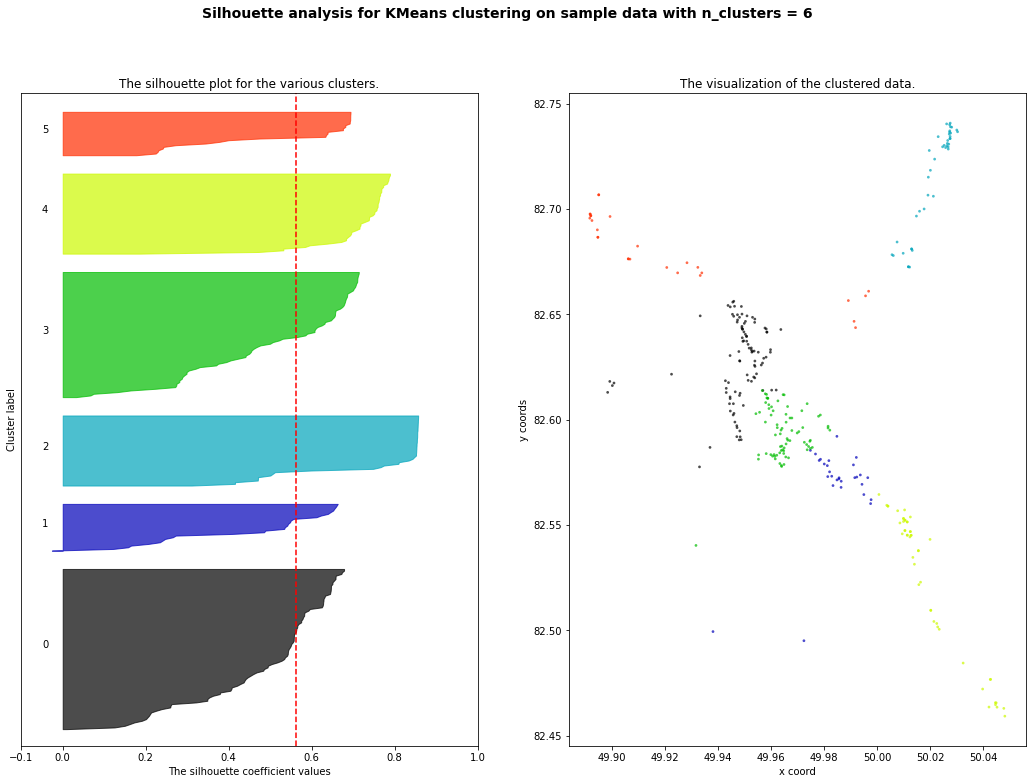

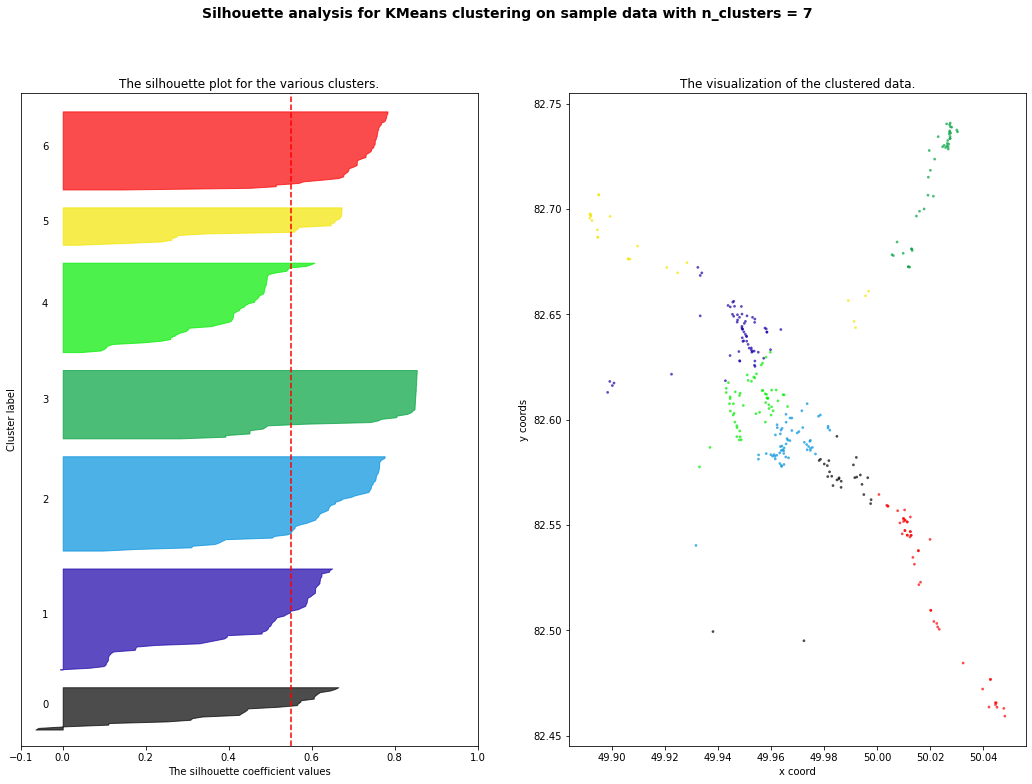

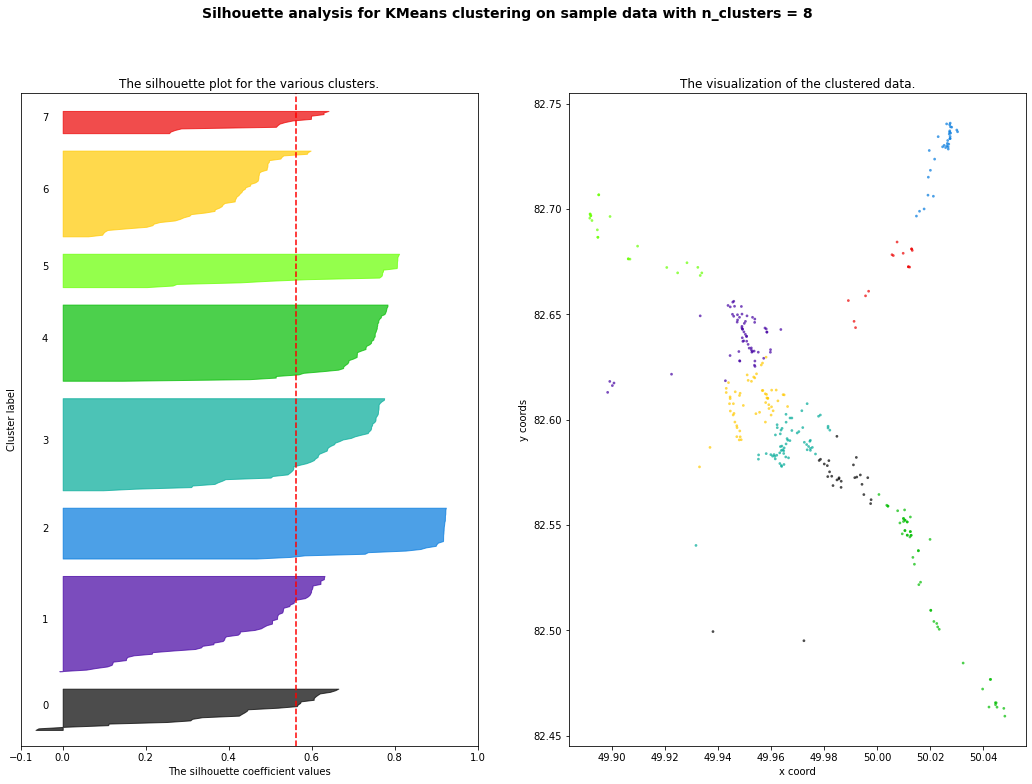

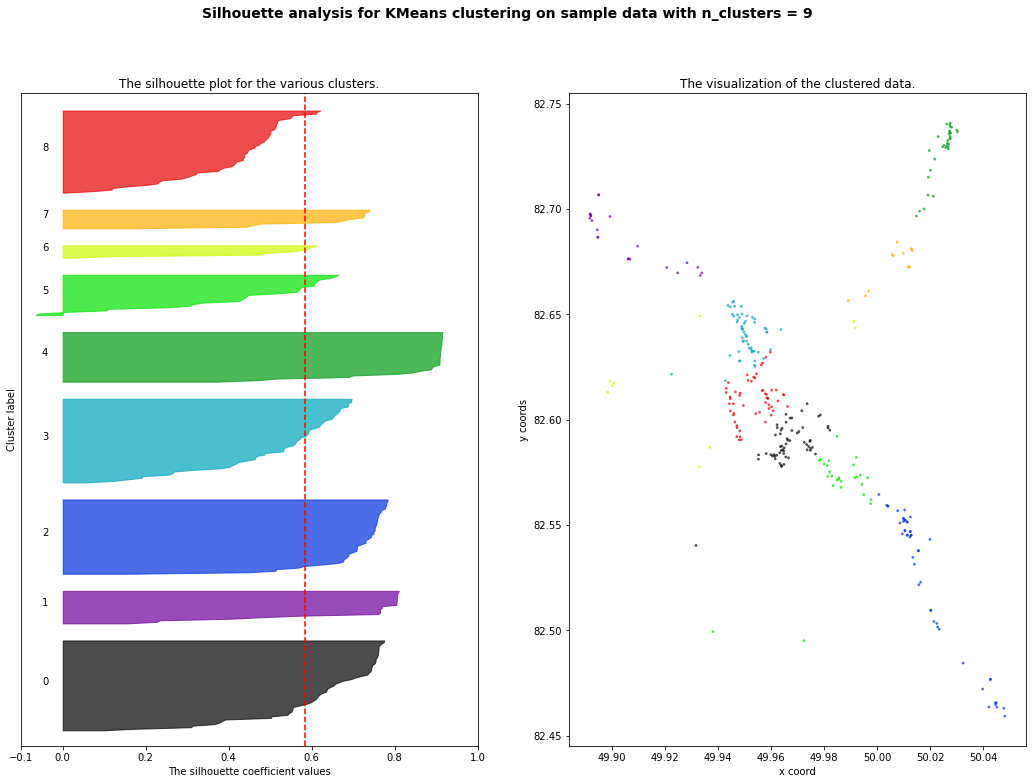

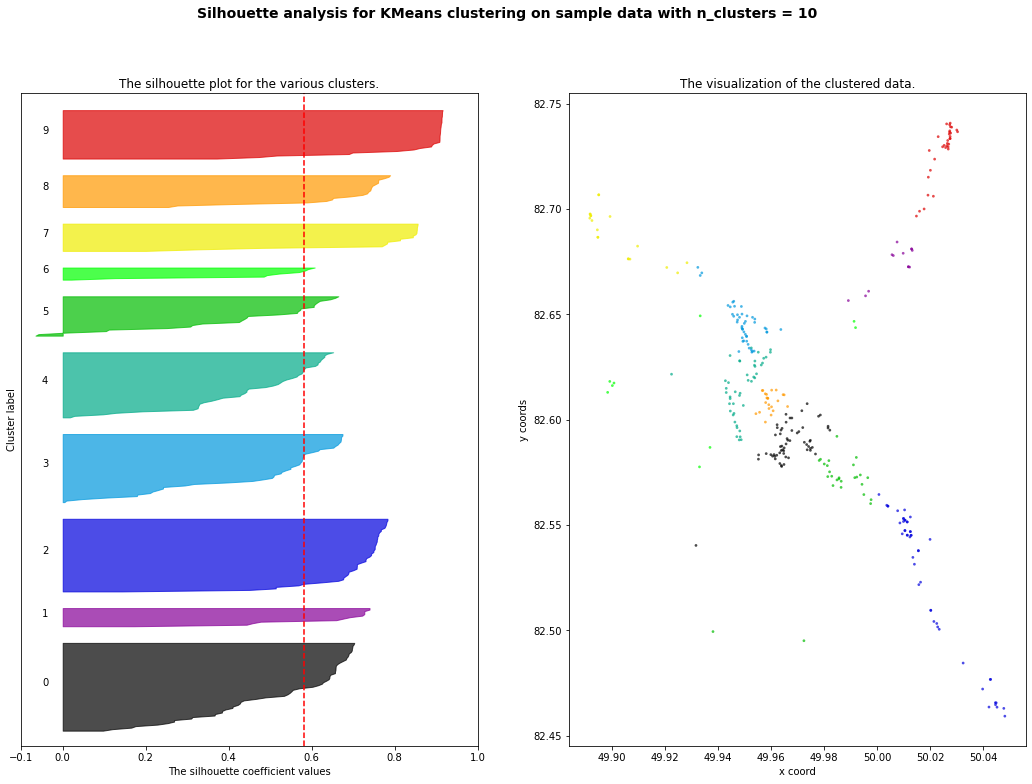

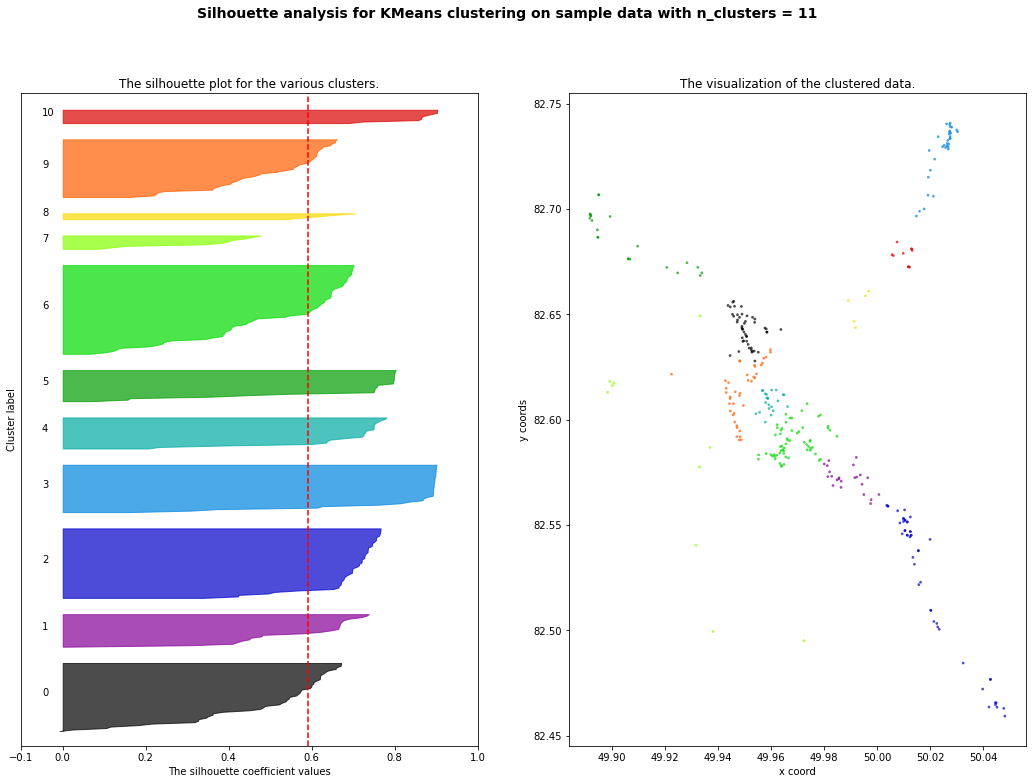

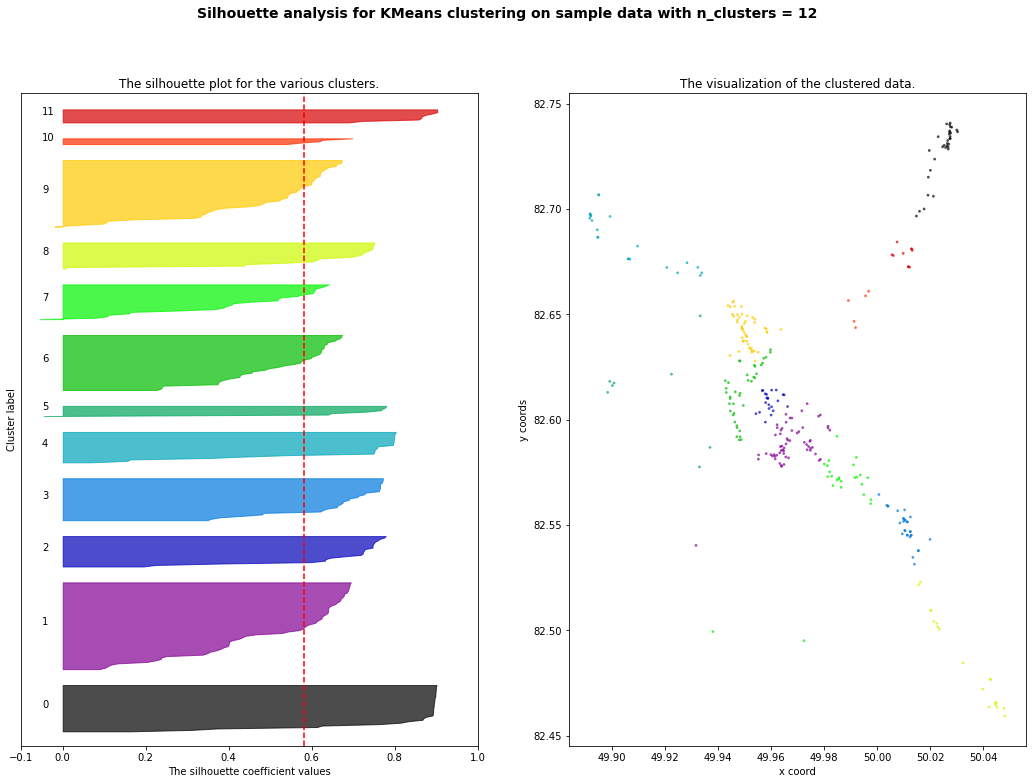

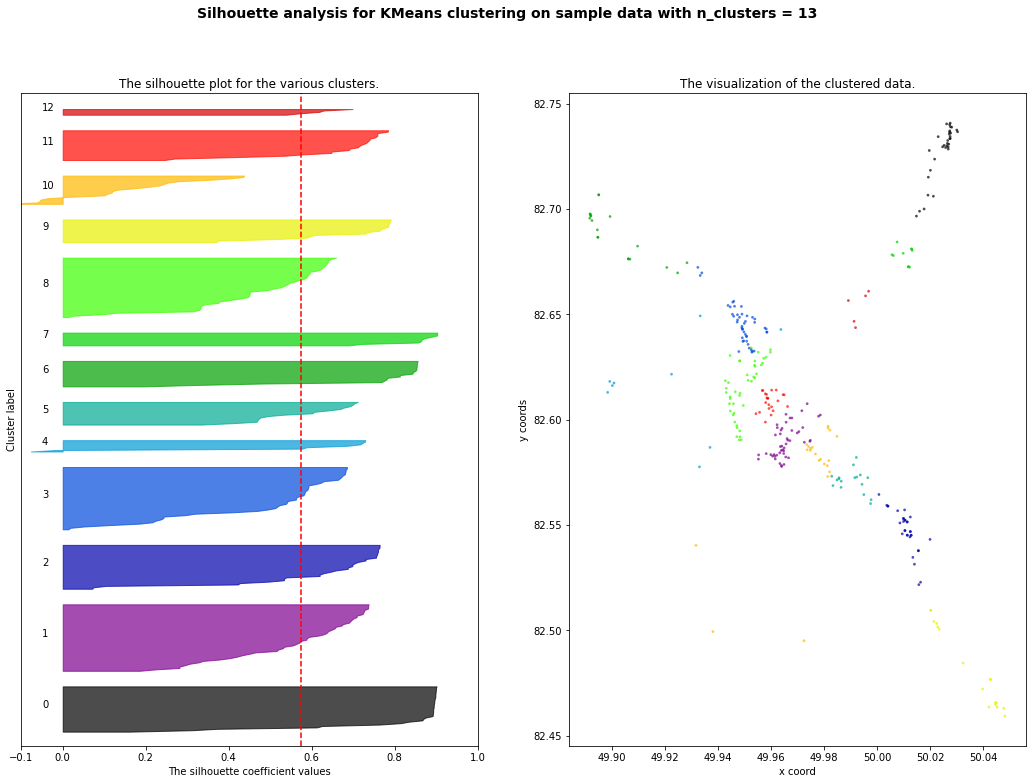

Wall time: 4.51 s


In [338]:
%%time
if data['K'] > 100:
    range_n_clusters = range(100, data['K']+1, 2)
else:
    range_n_clusters = range(2, data['K']+1, 1)
model_dict = {}

for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = silhouette_score(X, cluster_labels)

    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    
    model_dict['model_{0}'.format(n_clusters)] = {'model': clusterer,
                                                  'labels': cluster_labels,
                                                  'silhouette_avg': silhouette_avg,
                                                  'silhouette_values': sample_silhouette_values}
    
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 12)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        coords[:, 0], coords[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("x coord")
    ax2.set_ylabel("y coords")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

In [339]:
chosen_model = 'model_12'

## sorting the size of clusters in ascending order

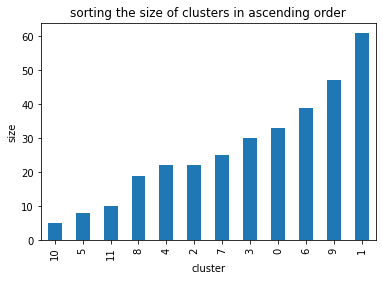

In [340]:
from collections import Counter

pd.Series({k: v for k, v in sorted(Counter(model_dict[chosen_model]['labels']).items(), key=lambda item: item[1])}).plot.bar()
plt.title('sorting the size of clusters in ascending order')
plt.ylabel('size')
plt.xlabel('cluster')
plt.show()

## cluster centers

In [341]:
df['cluster'] = model_dict[chosen_model]['labels']
cluster_centers = df.groupby('cluster').mean()
df.drop('cluster', axis=1, inplace=True)
cluster_centers

,lat,lng
cluster,,
0,50.024833,82.727902
1,49.967394,82.588576
2,49.959672,82.608587
3,50.010720,82.549037
4,49.905859,82.685984
5,49.915610,82.612552
6,49.949582,82.613090
7,49.985615,82.567115
8,50.033617,82.485746


## creating icon for visualization icon

In [342]:
import folium
from folium.features import DivIcon

def number_DivIcon(size,color,number):
    icon = DivIcon(
            icon_size=(150,36),
            icon_anchor=(14,40),
#             html='<div style="font-size: 18pt; align:center, color : black">' + '{:02d}'.format(num+1) + '</div>',
            html="""<span class="fa-stack " style="font-size: {}pt" >>
                    <!-- The icon that will wrap the number -->
                    <span class="fa fa-circle-o fa-stack-2x" style="color : {:s}"></span>
                    <!-- a strong element with the custom content, in this case a number -->
                    <strong class="fa-stack-1x">
                         {:02d}  
                    </strong>
                </span>""".format(size,color,number)
        )
    return icon

## plotting data and cluster's labels

In [343]:
%%time
m = folium.Map([df.mean()['lat'], df.mean()['lng']])

colors = ['darkred', 'pink', 'gray', 'red', 'lightgreen', 'green',
          'cadetblue', 'darkblue', 'darkgreen', 'black', 'beige',
          'white', 'blue', 'lightblue', 'darkpurple', 'lightgray',
          'purple', 'lightred', 'orange']

for obj_ind, row in enumerate(df.iterrows()):
    folium.Marker(
        location=[row[1]['lat'], row[1]['lng']],
        popup="index: {0}, cluster:{1}".format(row[0], model_dict[chosen_model]['labels'][obj_ind]),
        # icon=folium.Icon(color=colors[cluster_labels[obj_ind]]),
        icon=number_DivIcon(6,
                            list(mcolors.CSS4_COLORS.values())[(model_dict[chosen_model]['labels'][obj_ind]*5) % 148],
                            model_dict[chosen_model]['labels'][obj_ind])
    ).add_to(m)
    
# This commented code plots cluster centers by using avg coordinates, if you wanna see, uncomment it
# for cl_id, row in cluster_centers.iterrows():
#     folium.Marker(
#         location=[row[0], row[1]],
#         popup="cluster: {0}".format(cl_id),
#         icon=number_DivIcon(16, 'black', cl_id)
#     ).add_to(m)

m

Wall time: 68.3 ms


## saving model

In [330]:
filter_string = ['labels', 'silhouette_avg', 'silhouette_values']
filtered_dict = {k:v.tolist() for (k,v) in model_dict[chosen_model].items() if k in filter_string}
with open("answers/{0}_{1}.json".format(data_name, chosen_model), "w") as outfile:
    json.dump(filtered_dict, outfile)